In [1]:
from lea_utils import SimulatorLEA
from lea_utils import norm_values
from lea_utils import PlotLEA, split_sequences
# from lea_utils import *
import numpy as np
import pandas as pd
import tensorflow as tf
from lea_pinn import Struct,Logger,PhysicsInformedNN,Dataset_Pinn


In [2]:
#Intancia do simulador
simulador=SimulatorLEA()
filepath="./dados_experimentais/Dados_BCSLEA_20210818.mat"
#Carregar dados experimentais
intervalo_horas=(0,7) #Janela de simulação em horas escolhida com base no histórico de dados
simulador.getLEAdata(filepath,intervalo_horas)


0
 File loaded ./dados_experimentais/Dados_BCSLEA_20210818.mat


In [3]:
fk,zc,pman,pres=simulador.BCS_EXP.get_exo_values() # Armazenamento dos valores das exógenas
x1,x2,x3=simulador.BCS_EXP.get_ss_values() # Armazenamento dos valores dos estados

maxtime = fk.shape[0]
nsim=maxtime
delta_pm=0.17e5-0.04e5;delta_pr=2.2e5-1.5e5
norm_u=[[60,100,delta_pm,delta_pr],[0,0,0.04e5,1.5e5]]
norm_x=norm_values()
#norm_u=[[1,1,1,1],[0,0,0,0]]
tsteps=[30,10] #time-steps backward and forward
dataset=Dataset_Pinn([fk,zc,pman,pres,x1,x2,x3],norm_x,norm_u,tsteps)


In [4]:
dataset.u.shape

(252, 4)

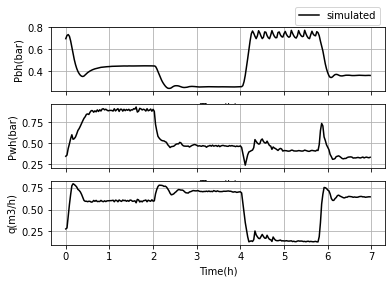

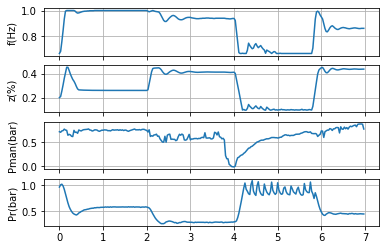

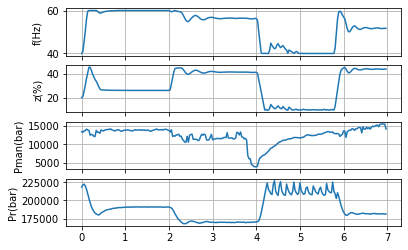

In [5]:
# Verificar Normalização
tempo=simulador.BCS_EXP.tempo_hora
fig=simulador.plotLEA.plot_states([[dataset.xn[:,0]*1e5,dataset.xn[:,1]*1e5,dataset.xn[:,2]/3600]],tempo)
fig=simulador.plotLEA.plot_exogenous([dataset.un[:,0],dataset.un[:,1],dataset.un[:,2]*1e5,dataset.un[:,3]*1e5],tempo)
fig2=simulador.plotLEA.plot_exogenous([dataset.u[:,0],dataset.u[:,1],dataset.u[:,2]*1e5,dataset.u[:,3]*1e5],tempo)


In [6]:
print(dataset.data.shape)
dataset.un.shape

(252, 7)


(252, 4)

In [7]:

#-------------------------------------
n_features=6 # two network inputs  (fk, zc,pmc,prn, x1,x2)
nu=4 #number of exogenous
n_measured=2 # number of measured states
# print(f"Input states to training: {train_X.shape[2]-u_train.shape[2]}")
# print(f"Input exogenous to training: {u_train.shape[2]}")
# print(f"States (y) used to compute Loss: {train_y.shape[2]}")
# print(f"Data used to prediction validation: {test_X.shape[2]}")
# print(f"States (y) used to compute validationLoss: {test_y.shape[2]}")
# print(train_X.shape)
# print(train_y.shape)
# print(u_train.shape)
# print(test_X.shape)
# print(test_y.shape)


In [8]:
#========================================
# # Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
nt_config = Struct()
#Positive integer. The number of iterations allowed to run in parallel. 
nt_config.parallel_iter=2
#The maximum number of iterations for L-BFGS updates. 
nt_config.maxIter = 20
#Specifies the maximum number of (position_delta, gradient_delta) correction pairs to keep as implicit approximation of the Hessian matrix. 
nt_config.nCorrection = 50
#If the relative change in the objective value between one iteration and the next is smaller than this value, the algorithm is stopped. 
nt_config.tolfun=1e-5
#Specifies the gradient tolerance for the procedure. If the supremum norm of the gradient vector is below this number, the algorithm is stopped. 
nt_config.tol = 1e-5 #Specifies the gradient tolerance for the procedure. If the supremum norm of the gradient vector is below this number, the algorithm is stopped. 

In [9]:
#========================================
# Creating the model and training
logger = Logger(frequency=50)
#logger.set_error_fn(error)
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
neurons=10

# start_rho=0.9*950/rho
# start_PI=0.9*2.32*1e-9/PI
# var=[start_rho, start_PI] # parâmetros normalizados
#var=[1.0, start_PI] # Problema direto
#var=[start_rho, 1.0] # Problema direto
var=[1.0, 1.0] # Problema direto
Nc=10

TensorFlow version: 2.6.0
Eager execution: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU-accerelated: False


In [10]:
pinn = PhysicsInformedNN(Nc,[30,10],tf_optimizer,logger,var=var,pinn_mode="on", inputs=n_features)


Training started
PINN Mode:1
Learning rate=:0.0100
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10)                680       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 10)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 10)            840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 3)             33        
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
__

In [11]:
#print(np.array(pinn.ODE(train_y_full,u_train,[1,1])))
# print(f"PINN:{np.array(pinn.ODE(train_y_full[0:1,:,:],u_train[0:1,:,:],[1,1]))}")
#print(train_y_full[0,:,:].shape,u_train[0,:,:].shape)
# ED.EDO(out,entrada)


In [12]:
Loss, trainstate,vartrain=pinn.fit(dataset, tf_epochs=100)

—— Starting Adam optimization —— Pinn_mode:1
==============Weights===============
[ bc ,  r1 ,  r2 ,  r3]
[1.000,1.000,1.000,1.000,
                                                    |======Common Residues======|=ED parameters=|
epoch | elap|  Total  | Loss BC |Loss ODE |  Test   |    r1  |   r2   |  r3    | rho |   PI    |
     0 00:06 2.313e+05 2.901e-01 2.313e+05 1.113e-01|5.22e+03,2.11e+02,2.26e+05|836.9 2.70e-08
    50 00:15 7.065e+03 2.122e-02 7.065e+03 1.427e-01|3.17e+02,1.57e+01,6.73e+03|836.9 2.70e-08
Training finished (epoch 100): duration = 00:23  Test = 1.3474e-01  
Best model at step:11, Best rho:836.9, Best PI:2.7000e-08
  train loss: 4.76e+04
  test loss: 2.61e-02


In [13]:
#Loss, trainstate,vartrain=pinn.fit_LBFGS(train_X, train_y,u_train, nt_config)
# Loss, trainstate,vartrain=pinn.fit_LBFGS(dataset, nt_config)

In [14]:
from matplotlib import pyplot as plt
Font=14

In [15]:
def plot_result(pred_train, pred_test, obs):
    
    # if obs.shape[-1]==2:
    #     obs=obs*xc[0:2]+x0[0:2]
    # if obs.shape[-1]==3:
    #     obs=obs*xc+x0

    plt.figure(figsize=(20, 4))
    #y_mean = np.mean(prediction1)
    k = np.arange(0,len(obs))
    ktr=np.arange(0+n_steps_in,len(pred_train)+n_steps_in)
    kts=np.arange(len(pred_train)+n_steps_in,len(pred_train)+len(pred_test)+n_steps_in)
    Fig=plt.figure()
    ax1=Fig.add_subplot(3,1,1)
    
    #print(ktr.shape)
    ax1.plot(k, obs[:,0]/1e5,"k", label='History')
    ax1.plot(ktr, pred_train[:,0]/1e5,":",color='red',lw=2,label='Forecasted with LSTM')
    ax1.plot(kts, pred_test[:,0]/1e5,":",color='blue',lw=2,label='GroundTruth')
    ax1.set_ylabel("$P_{bh}(bar)$",  fontsize=Font)
    
    ax1.set_xticklabels([])
    ax1.grid(True)
    plt.grid(True)
    ax2=Fig.add_subplot(3,1,2)
    ax2.set_ylabel("$P_{wh}(bar)$",  fontsize=Font)
    ax2.plot(k, obs[:,1]/1e5,"k", label='History')
    ax2.plot(ktr, pred_train[:,1]/1e5,":",color='red',lw=2,label='Forecasted with LSTM')
    ax2.plot(kts, pred_test[:,1]/1e5,":",color='blue',lw=2,label='GroundTruth')
    
    ax2.set_xticklabels([])
    ax2.grid(True)
    plt.grid(True)
    ax3=Fig.add_subplot(3,1,3)
    ax3.set_ylabel("$q (m^3/h)$",  fontsize=Font)
    ax3.plot(k, (x3n*xc[2]+x0[2])*3600,"k", label='Observed data')
    ax3.plot(ktr, pred_train[:,2]*3600,":",color='red',lw=2,label='Train predicted')
    ax3.plot(kts, pred_test[:,2]*3600,":",color='blue',lw=2,label='Test predicted')
    
    plt.grid(True)
    #plt.legend(loc='upper left')
    
    ax3.set_xlabel('$Time(s)$' ,  fontsize=Font)
    plt.legend(bbox_to_anchor=(1, 3.8), ncol = 3)
    return Fig

def prep_data(model,x_test, y_test , start , end , last):
    #prepare test data X
    dataset_test = x_test
    dataset_test_X = dataset_test[start:end, :]
    print("dataset_test_X :",dataset_test_X.shape)
    test_X_new = dataset_test_X.reshape(1,dataset_test_X.shape[0],dataset_test_X.shape[1])
    print("test_X_new :",test_X_new.shape)#prepare past and groundtruth
    npast=end-5*n_steps_in
    past_data = y_test[npast:end , :]
    dataset_test_y = y_test[end:last , :]
    print("dataset_test_y :",dataset_test_y.shape)
    print("past_data :",past_data.shape)#predictions
    y_pred = model.predict(test_X_new)
    y_pred_inv = y_pred
    y_pred_inv = y_pred_inv.reshape(n_steps_out,3)
    y_pred_inv = y_pred_inv[:,:]
    print("y_pred :",y_pred.shape)
    print("y_pred_inv :",y_pred_inv.shape)
    
    return y_pred_inv , dataset_test_y , past_data#start can be any point in the test data (1258)

def prep_data_plot(model,dataset):
    train_X,_,_=dataset.dataset_LBFGS
    test_X , _ =dataset.Test
    n_steps_out = dataset.t_steps[1]
    xc,x0=dataset.xc,dataset.x0

    y_pred_train=model.predict(train_X)
    y_pred_train=y_pred_train.reshape(y_pred_train.shape[0]*y_pred_train.shape[1],y_pred_train.shape[2])
    y_pred_test=model.predict(test_X)
    y_pred_test=y_pred_test.reshape(y_pred_test.shape[0]*y_pred_test.shape[1],y_pred_test.shape[2])
    for i in range(y_pred_train.shape[0]):
        k=i*n_steps_out
        if k==0:
            pred_train=y_pred_train[k:k+1,:]
        pred_train=np.vstack((pred_train,y_pred_train[k:k+1,:]))
        if k==y_pred_train.shape[0]:
            #print(k)
            break
    
    for i in range(y_pred_test.shape[0]):
        k=i*n_steps_out
        if k==0:
            pred_test=y_pred_test[k:k+1,:]
        pred_test=np.vstack((pred_test,y_pred_test[k:k+1,:]))
        if k==y_pred_train.shape[0]:
            break
        
    return pred_train*xc.T+x0.T, pred_test*xc.T+x0.T


No handles with labels found to put in legend.


(37, 10, 4)


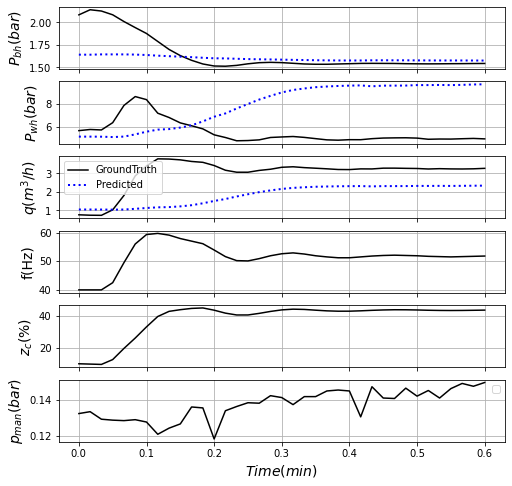

In [21]:
def plot_test(pred_test, obs, u_test,step):
    Font=14
    xc,x0=dataset.xc.T,dataset.x0.T
    pred_test=pred_test[:,step,:]*xc+x0
    obs=obs[:,step,:]
    u_test=u_test[:,step,:]

 
    if obs.shape[-1]==2:
        obs=obs*xc[:,0:2]+x0[:,0:2]
    if obs.shape[-1]==3:
        obs=obs*xc+x0
    
    k=np.arange(0,obs.shape[0])/60
    Fig=plt.figure(figsize=(8, 8))
    sc=[1/1e5, 1/1e5,3600]
    sc_u=[1, 1,1/1e5]
    label=["$P_{bh}(bar)$","$P_{wh}(bar)$", "$q (m^3/h)$"]
    label_u = ['f(Hz)',r'$z_c$(%)', "$p_{man} (bar)$"];
    for i,lb in enumerate(label):        
        ax1=Fig.add_subplot(len(label+label_u),1,i+1)
        ax1.plot(k, obs[:,i]*sc[i],"-k", label='GroundTruth')
        ax1.plot(k, pred_test[:,i]*sc[i],":",color='blue',lw=2,label='Predicted')
        ax1.set_ylabel(lb,  fontsize=Font)
        ax1.set_xticklabels([])
        
        ax1.grid(True)
    plt.legend()
    for i,lb in enumerate(label_u):
        ax1=Fig.add_subplot(len(label+label_u),1,i+1+3)
        ax1.plot(k, u_test[:,i]*sc_u[i],"-k")
        ax1.set_ylabel(lb,  fontsize=Font)
        ax1.grid(True)
        if i!=2:
            ax1.set_xticklabels([])
    ax1.set_xlabel('$Time (min)$' ,  fontsize=Font)
    #plt.legend(bbox_to_anchor=(1, 3.8), ncol = 3)
    plt.legend()
    return Fig
Uk=dataset.u

Fig2save={}
ypred=pinn.u_model.predict(dataset.Test[0])
Fig_operation_7=plot_test(ypred, dataset.TestFull[1],dataset.u_test,0)
print(dataset.u_test.shape)

In [17]:
# x_test=dset[:,0:3]
# y_test=dset[:,3:]
pred_train,pred_test=prep_data_plot(pinn.u_model,dataset)
pinn.u_model.reset_metrics()

In [18]:
dataset.xc.shape

(3, 1)

In [19]:

Fig_result=plot_result(pred_train, pred_test,dataset.Test[1][:,0,:]*dataset.xc[0:2]+dataset.x0[0:2])

# vartrain.plot_var()
# Loss.plot_loss_res()

InvalidArgumentError: Incompatible shapes: [37,2] vs. [2,1] [Op:Mul]